In [1]:
### If testing, data is randomly generated, and plots are not saved.
### For performing the analysis with actual data, set TEST = False.
TEST = True 

Figure 2A left: Controllability of the system with individual EMIs

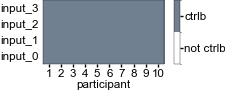

In [2]:
from ctrl.discrete_optimal_control import LQR
from ctrl import utils
from custom_rcparams_paper import colors
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

if TEST:
    data = utils.generate_random_dataset(10, 50)
else:
    data = utils.load_data()
    os.makedirs('figures', exist_ok=True)
features = data[0]['Xlabs']
intervs = data[0]['Ilabs']
controllable = np.zeros((len(data), len(intervs)), dtype=bool)

for j in range(len(data)):
    X = data[j]['X']
    A = data[j]['A']
    B = data[j]['B']
    for i in range(len(intervs)):
        controllable[j,i] = LQR.controllable(A, B[:,i:i+1])     # For controllability of single EMIs, cut out the column of B representing that EMI

fig, ax = plt.subplots(figsize=(1.8,0.9))
cmap = colors.binary_cmap
ax, cbar = utils.colorplot_trajectory(controllable, labels=intervs, ax=ax, cmap=cmap,
                                      norm=mpl.colors.BoundaryNorm([-0.5,0.5,1.5], 200),
                                      origin='lower')
ax.set_xticks(range(len(data)), labels=range(1, len(data)+1))
ax.set_xlabel('participant')
cbar.ax.set_yticks([0,1], labels=['not ctrlb', 'ctrlb'])
if not TEST:
    plt.savefig('figures/figure2Al.png')
    plt.savefig('figures/figure2Al.svg')

Figure 2A right: Average controllability of EMIs and 'Company'

T-Test: Overall AC of EMIs > AC of 'Company':
TtestResult(statistic=6.261413760289144, pvalue=0.00014760998119133618, df=9)
Standard deviation of ACs:
[15.45578469 11.34799844 36.17949101 13.52987703]


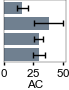

In [3]:
from scipy import stats
from ctrl.discrete_optimal_control import LQR
from ctrl import utils
import numpy as np
import matplotlib.pyplot as plt
from custom_rcparams_paper import colors

if TEST:
    data = utils.generate_random_dataset(10, 50)
else:
    data = utils.load_data()
    os.makedirs('figures', exist_ok=True)    
features = data[0]['Xlabs']
intervs = data[0]['Ilabs']
AC = np.zeros((len(data), len(intervs)))

for j in range(len(data)):
    X = data[j]['X']
    A = data[j]['A']
    B = data[j]['B']
    for i in range(len(intervs)):
        gramian = LQR.ctrb_gramian(A, B[:,i:i+1], 15)   # Average controllability is the trace of the ctrb gramian
        AC[j,i] = np.diag(gramian).sum()

fig, ax = plt.subplots(figsize=(0.7,0.9))
ax.barh(range(len(intervs)), AC.mean(axis=0), xerr=stats.sem(AC, axis=0),
        color=colors.standard, ecolor=colors.errorbars)
ax.set_yticks([])
ax.set_xticks([0,25,50])
ax.set_ylim([-0.5, len(intervs)-0.5])
ax.tick_params(which='major', left=False)
ax.set_xlabel('AC')
if not TEST:
    plt.savefig('figures/figure2Ar.png')
    plt.savefig('figures/figure2Ar.svg')

print("T-Test: Overall AC of EMIs > AC of 'Company':")
print(stats.ttest_rel(AC[:,:3].mean(axis=1), AC[:,3]))

print('Standard deviation of ACs:')
print(AC.std(0))

Figure 2B: Average Controllability of individual items (median and number of occurrences among the top 4)

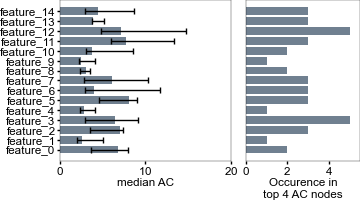

In [4]:
from ctrl.discrete_optimal_control import LQR
from ctrl import utils
import numpy as np
import matplotlib.pyplot as plt
from custom_rcparams_paper import colors
from scipy import stats
import os

if TEST:
    data = utils.generate_random_dataset(10, 50)
else:
    data = utils.load_data()
    os.makedirs('figures', exist_ok=True)     
features = data[0]['Xlabs']
intervs = data[0]['Ilabs']
ac = np.zeros((len(data), len(features)))
mc = np.zeros((len(data), len(features)))

### Can plot either mean or median of average controllabilities
statistic = 'median'

for j in range(len(data)):
    X = data[j]['X']
    A = data[j]['A']
    B = data[j]['B']
    ### For the left panel: Determine average controllability
    ac[j] = LQR.average_ctrb(A, 15)

### For the right panel: Determine how often each item occurs among the top 4 items w.r.t. average controllability
top4ac = np.r_[np.argsort(ac, axis=1)[:,-1:-5:-1].flatten(), np.arange(len(features))].copy()
_, top4ac_counts = np.unique(top4ac, return_counts=True)
top4ac_counts -= 1

fig, axes = plt.subplots(1,2, figsize=(3.6,2), sharey=True, gridspec_kw={'width_ratios':(1.5,1)})
ax = axes[0]

if statistic=='median':
    interval = np.vstack((np.percentile(ac, 25, axis=0), np.percentile(ac, 75, axis=0)))
    bar_container = ax.barh(range(len(features)), np.median(ac, axis=0), color=colors.features,
            xerr=np.abs(np.median(ac, axis=0, keepdims=True)-interval), error_kw={'linewidth':1}, ecolor=colors.errorbars)
    ax.set_xlabel('median AC')
    ax.set_xticks([0,10,20])
elif statistic=='mean':
    interval = stats.sem(ac, axis=0)
    bar_container = ax.barh(range(len(features)), np.mean(ac, axis=0), color=colors.features,
            xerr=interval, error_kw={'linewidth':1}, ecolor=colors.errorbars)
    ax.set_xlabel('mean AC')
    ax.set_xticks([0,20,40])

ax.set_yticks(np.arange(len(features)), labels=features)
ax = axes[1]
ax.barh(range(len(features)), top4ac_counts)
ax.set_xlabel('Occurence in\ntop 4 AC nodes')
ax.set_xticks([0,2,4])
ax.set_xlim([0, 5.5])
ax.tick_params(left=False)
if not TEST:
    plt.savefig('figures/figure2B.png')
    plt.savefig('figures/figure2B.svg')

Figure 2C: Visualization of VAR(1) model as a network graph

Connections with p<0.05:
feature_0 -> feature_11: p=0.042
feature_0 -> feature_12: p=0.037
feature_2 -> feature_5: p=0.009
feature_2 -> feature_6: p=0.008
feature_4 -> feature_1: p=0.036
feature_4 -> feature_5: p=0.042
feature_4 -> feature_12: p=0.028
feature_5 -> feature_0: p=0.011
feature_5 -> feature_2: p=0.034
feature_5 -> feature_4: p=0.021
feature_5 -> feature_12: p=0.040
feature_7 -> feature_5: p=0.045
feature_7 -> feature_12: p=0.046
feature_8 -> feature_2: p=0.046
feature_9 -> feature_0: p=0.007
feature_9 -> feature_12: p=0.005
feature_10 -> feature_5: p=0.017
feature_12 -> feature_3: p=0.016
feature_12 -> feature_11: p=0.034
feature_13 -> feature_11: p=0.012
feature_13 -> feature_14: p=0.001


C:\Users\janik.fechtelpeter\AppData\Local\Temp\ipykernel_13700\1882474591.py:43: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


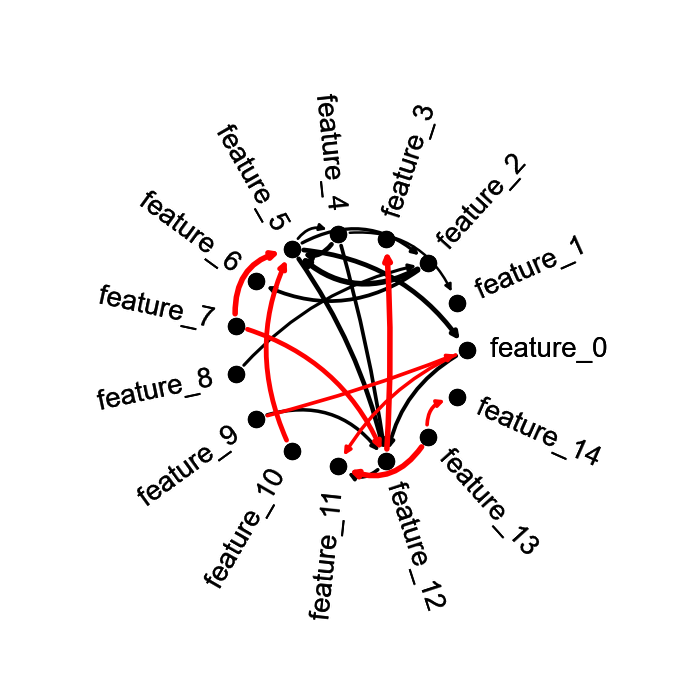

In [5]:
from scipy import stats
import matplotlib.pyplot as plt
from ctrl import utils
import numpy as np
from custom_rcparams_paper import colors

if TEST:
    data = utils.generate_random_dataset(10, 50)
else:
    data = utils.load_data()
    os.makedirs('figures', exist_ok=True)     

features = data[0]['Xlabs']
A_matrices = np.zeros((len(data), len(features), len(features)))

for j in range(len(data)):
    A = data[j]['A']
    A_matrices[j] = A
sig_adj = stats.ttest_1samp(A_matrices, 0, axis=0).pvalue   # Show only connections with a weight significantly different from 0

fig, ax = plt.subplots(figsize=(7,7))
ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
A_mean = A_matrices.mean(axis=0)
for i in range(A_mean.shape[0]):
    A_mean[i,i] = 0                                     # Do not show auto-connections
A_plus = np.where((sig_adj < 0.05) & (A_mean > 0),      # Separate negative from positive connections to display them in different colors
                  A_mean, 0)
A_minus = np.where((sig_adj < 0.05) & (A_mean < 0), 
                  A_mean, 0) * (-1)
utils.plot_circular_graph(A_plus, directed=True, labels=features, 
                          max_edge_width=4, max_edge_rad=-0.6,
                          node_kwargs={'node_size': 150, 'node_color': 'black'},
                          label_kwargs={'font_family': 'sans-serif', 'font_size': 20},
                          ax=ax)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
utils.plot_circular_graph(A_minus, directed=True, labels=features,
                          max_edge_width=4, max_edge_rad=-0.6, 
                          node_kwargs={'node_size': 150, 'node_color': 'black'}, 
                          edge_kwargs={'edge_color': 'r'},
                          label_kwargs={'font_family': 'sans-serif', 'font_size': 20},
                          ax=ax)
fig.tight_layout()
if not TEST:
    plt.savefig('figures/figure2C.png')
    plt.savefig('figures/figure2C.svg')

### Print the p value of the significant connections
print('Connections with p<0.05:')
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if sig_adj[i,j] < 0.05 and i!=j:
            print(f'{features[i]} -> {features[j]}: p={sig_adj[i,j]:0.3f}')

Figure 2D: Scatter plot of edge weight vs. AC of items

Correlation of edge weights vs. log AC: PearsonRResult(statistic=0.47125973703459234, pvalue=1.1538468740662313e-09)


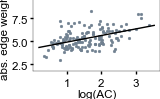

In [6]:
from ctrl.discrete_optimal_control import LQR
from ctrl import utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from custom_rcparams_paper import colors
import os

if TEST:
    data = utils.generate_random_dataset(10, 50)
else:
    data = utils.load_data()
    os.makedirs('figures', exist_ok=True)   
features = data[0]['Xlabs']
intervs = data[0]['Ilabs']
ac = np.zeros((len(data), len(features)))
sum_incoming_weights = np.zeros((len(data), len(features)))
sum_outgoing_weights = np.zeros((len(data), len(features)))

for j in range(len(data)):
    A = data[j]['A']
    ac[j] = LQR.average_ctrb(A, 15)
    sum_incoming_weights[j] = np.sum(np.abs(A), axis=1)     # Incoming weights are rows of A
    sum_outgoing_weights[j] = np.sum(np.abs(A), axis=0)     # Outgoing weights are columns of A

with mpl.rc_context({'lines.markersize':2}):
    fig, ax = plt.subplots(figsize=(1.6,1))
    ax, corr = utils.plot_regression(np.log(ac).flatten(), (sum_incoming_weights + sum_outgoing_weights).flatten(), ax=ax,
                        scatter_kwargs={'color':colors.standard}, line_kwargs={'color':'k'})
    ax.set_xlabel('log(AC)')
    ax.set_ylabel('abs. edge weight')
    ax.set_ylim(np.array(ax.get_ylim()) + np.array([-1, 1]))
    if not TEST:
        plt.savefig('figures/figure2D.png')
        plt.savefig('figures/figure2D.svg')

print(f'Correlation of edge weights vs. log AC: {corr}')

Figure 2E: Modal Controllability of individual items

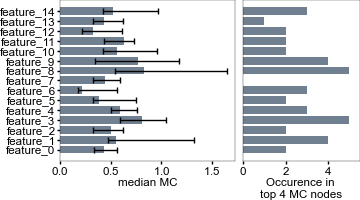

In [7]:
from ctrl.discrete_optimal_control import LQR
from ctrl import utils
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from custom_rcparams_paper import colors
import os

if TEST:
    data = utils.generate_random_dataset(10, 50)
else:
    data = utils.load_data()
    os.makedirs('figures', exist_ok=True) 
features = data[0]['Xlabs']
intervs = data[0]['Ilabs']
mc = np.zeros((len(data), len(features)))

### Can plot either mean or median of average controllabilities
statistic = 'median'

for j in range(len(data)):
    X = data[j]['X']
    A = data[j]['A']
    B = data[j]['B']
    ### For the left panel: Determine modal controllability
    mc[j] = LQR.modal_ctrb(A)

### For the right panel: Determine how often each item occurs among the top 4 items w.r.t. modal controllability
top4mc = np.r_[np.argsort(mc, axis=1)[:,-1:-5:-1].flatten(), np.arange(len(features))].copy()
_, top4mc_counts = np.unique(top4mc, return_counts=True)
top4mc_counts -= 1

fig, axes = plt.subplots(1,2, figsize=(3.6,2), sharey=True, gridspec_kw={'width_ratios':(1.5,1)})
ax = axes[0]
if statistic=='median':
    interval = np.vstack((np.percentile(mc, 25, axis=0), np.percentile(mc, 75, axis=0)))
    bar_container = ax.barh(range(len(features)), np.median(mc, axis=0), color=colors.features,
            xerr=np.abs(np.median(mc, axis=0, keepdims=True)-interval), error_kw={'linewidth':1}, ecolor=colors.errorbars)
    ax.set_xlabel('median MC')
elif statistic=='mean':
    interval = stats.sem(mc, axis=0)
    bar_container = ax.barh(range(len(features)), np.mean(mc, axis=0), color=colors.features,
            xerr=interval, error_kw={'linewidth':1}, ecolor=colors.errorbars)
    ax.set_xlabel('mean MC')
ax.set_yticks(np.arange(len(features)), labels=features)
ax = axes[1]
ax.barh(range(len(features)), top4mc_counts)
ax.set_xlabel('Occurence in \ntop 4 MC nodes')
ax.set_xticks([0,2,4])
ax.set_xlim([0, 5.5])
ax.tick_params(left=False)
if not TEST:
    plt.savefig('figures/figure2E.png')
    plt.savefig('figures/figure2E.svg')

Additional Analysis: Edge Weight vs. Average Controllability vs. Modal Controllability

d:\ZI Mannheim\Control Theory\project_EMIcompass\.venv\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


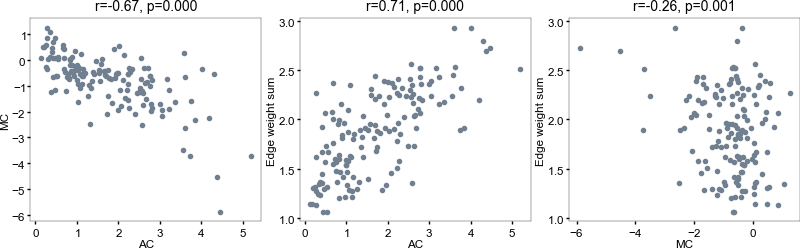

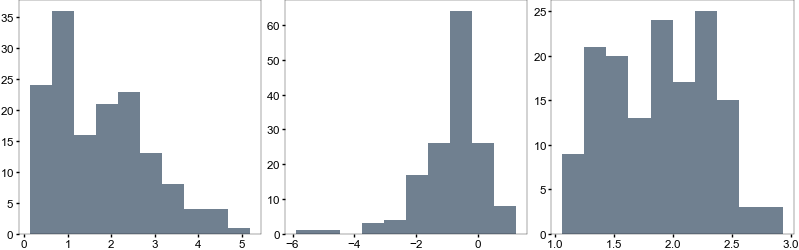

In [8]:
from ctrl.discrete_optimal_control import LQR
from ctrl import utils
import numpy as np
from scipy import stats
import custom_rcparams_paper as crc
import itertools as it

data = utils.load_data(3)    
features = data[0]['Xlabs']
intervs = data[0]['Ilabs']
ac = np.zeros((len(data), len(features)))
mc = np.zeros((len(data), len(features)))
adj = np.zeros((len(data), len(features)))

for j in range(len(data)):
    A = data[j]['A']
    ac[j] = LQR.average_ctrb(A, 15)
    mc[j] = LQR.modal_ctrb(A)
    adj[j] = np.abs(A).sum(axis=0) + np.abs(A).sum(axis=1)
    corr = stats.pearsonr(ac[j], mc[j])

fig, axes = plt.subplots(1,3, figsize=(8,2.5))
labels = ['AC', 'MC', 'Edge weight sum']
measures = [ac, mc, adj]
for k, (x, y) in enumerate(it.combinations(range(3), 2)):
    corr = stats.pearsonr(np.log(measures[x].flatten()), np.log(measures[y].flatten()))
    axes[k].plot(np.log(measures[x].flatten()), np.log(measures[y].flatten()), marker='o', linestyle='')
    axes[k].set_xlabel(labels[x])
    axes[k].set_ylabel(labels[y])
    axes[k].set_title(f'r={corr.statistic:.2f}, p={corr.pvalue:.3f}')

fig, axes = plt.subplots(1,3,figsize=(8,2.5))
axes[0].hist(np.log(ac.flatten()))
axes[1].hist(np.log(mc.flatten()))
axes[2].hist(np.log(adj.flatten()));